# required libraries

In [ ]:
import numpy as np
import pandas as pd
import random as rn

pd.set_option("display.max_rows",None)
pd.set_option("display.max_columns",None)

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from collections import Counter

import warnings
warnings.filterwarnings("ignore")

# models:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# metrics
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score ,auc
from sklearn.metrics import roc_curve , auc


# required manual functions

In [ ]:
def dataset_analysis(df):
  """
   this function takes dataframe as input and gives some description and details are generated.
  """
  print("This dataset having {0} rows and {1} columns.".format(df.shape[0],df.shape[1]))
  int_cols=[]
  float_cols = []
  obj_cols=[]
  for i in df.columns[:]:
    if df[i].dtype == "int":
      int_cols.append(i)
    elif df[i].dtype == "float":
        float_cols.append(i)
    else:
        obj_cols.append(i)
    
  print("dataset have {0} integer type & {1} float type & {2} object type".format(len(int_cols),len(float_cols),len(obj_cols)))
  print("-"*50)
  print(df.info())
  print("-"*50)
  #print(df.head(3))
  return df.head(3)
  #print(df.describe())

In [ ]:
def missingdata_pts(df):
  """
     this function takes dataframe as input and check there is any missing /Nan values are existed in that dataframe.
  """
  # check the missing values in the given dataset.
  print("the missing values in the given dataset is {0}.".format(df.isna().sum().sum()))

In [ ]:
# removing the constant features
def constant_features(df):
  """
    Constant Feature: Same value in all the records. 
    it takes dataframe as input and remove the constant features because those kind of features are not useful for classification.
  """
  constant_columns = []
  for i in df.columns[:]:
    if df[i].nunique() == 1:
      constant_columns.append(i)
  print("{0} of constant features in the given dataframe".format(len(constant_columns)))
  return constant_columns

In [ ]:
def quasiconstant_features(df):
  """
  Quasi Constant Feature: One of the values is dominant 99.9%.
  """
  import sklearn
  from sklearn.feature_selection import VarianceThreshold
  a = VarianceThreshold(threshold=0.01)
  a.fit(df)
  quasi_columns = df.columns[:][~a.get_support()]
  print("The no of quasiconstant features in the given dataframe:{}".format(len(quasi_columns)))
  return quasi_columns

In [ ]:
def duplicate_feature_removal(df):
  """
     this function takes dataframe as input and remove the duplicated valued features.
  """
  # drop the duplicated features in terms of names and values.
  a=df.shape[1]
  #A.T.drop_duplicates(keep="last").T
  df = df.T.drop_duplicates(keep="first").T
  c= df.shape[1]
  print("The no of duplicated columns are removed having same values : ",(a-c))
  return df

In [ ]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    #print("Number of misclassified points ",(len(test_y)-np.trace(C))/len(test_y)*100)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    B =(C/C.sum(axis=0))
    
    labels = [0,1] #,3,4,5,6,7,8,9]
    cmap=sns.light_palette("green")
    # representing A in heatmap format
    print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*50, "Precision matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of columns in precision matrix",B.sum(axis=0))
    
    # representing B in heatmap format
    print("-"*50, "Recall matrix"    , "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of rows in precision matrix",A.sum(axis=1))

In [ ]:
def class_distribution(y_train,y_test):
  """
    this function just gives the distribution of the dataset based on the class labels of the target after splitting the data
  """
  # it returns a dict, keys as class labels and values as the number of data points in that class
  train_class_distribution = y_train.value_counts()
  test_class_distribution = y_test.value_counts()

  my_colors = ['#b23850', '#3b8beb'] #, '#e7e3d4', '#c4dbf6', '#8590aa', '#0d19a3', '#15db95', '#080f5b', '#f79e02']
  train_class_distribution.plot(kind='bar', color=my_colors)
  plt.xlabel('target')
  plt.ylabel('Data points per Class')
  plt.title('Distribution of yi in train data')
  plt.grid()
  plt.show()

  # ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
  # -(train_class_distribution.values): the minus sign will give us in decreasing order
  sorted_yi = np.argsort(-train_class_distribution.values)
  for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i]/y_train.shape[0]*100), 3), '%)')

  print('-'*80)
  my_colors = ['#b23850', '#3b8beb'] # , '#e7e3d4', '#c4dbf6', '#8590aa', '#0d19a3', '#15db95', '#080f5b', '#f79e02']
  test_class_distribution.plot(kind='bar', color=my_colors)
  plt.xlabel('Class')
  plt.ylabel('Data points per Class')
  plt.title('Distribution of yi in test data')
  plt.grid()
  plt.show()

  # ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
  # -(train_class_distribution.values): the minus sign will give us in decreasing order
  sorted_yi = np.argsort(-test_class_distribution.values)
  for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/y_test.shape[0]*100), 3), '%)')


# load kaggle dataset

In [ ]:
from google.colab import files
json = files.upload()

Saving kaggle.json to kaggle (1).json


In [ ]:
#load the dataset from the kaggle : https://www.kaggle.com/c/santander-customer-satisfaction/data
!mkdir kaggle # create kaggle directory

!cp kaggle.json ~/.kaggle/ # copy the kggle.json into kaggle directory
!chmod 600 ~/.kaggle/kaggle.json # changing the operation
!kaggle competitions download -c santander-customer-satisfaction # download the dataset by using the kaggle api

mkdir: cannot create directory ‘kaggle’: File exists
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# unzip the files
!unzip train.csv
!unzip test.csv

Archive:  train.csv
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
Archive:  train.csv.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
Archive:  test.csv
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
Archive:  test.csv.zip
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [ ]:
# load the dataset

dataframe_train = pd.read_csv("train.csv")
dataset_analysis(dataframe_train)

This dataset having 76020 rows and 371 columns.
dataset have 260 integer type & 111 float type & 0 object type
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB
None
--------------------------------------------------


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var1,ind_var2_0,ind_var2,ind_var5_0,ind_var5,ind_var6_0,ind_var6,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13_largo,ind_var13_medio_0,ind_var13_medio,ind_var13,ind_var14_0,ind_var14,ind_var17_0,ind_var17,ind_var18_0,ind_var18,ind_var19,ind_var20_0,ind_var20,ind_var24_0,ind_var24,ind_var25_cte,ind_var26_0,ind_var26_cte,ind_var26,ind_var25_0,ind_var25,ind_var27_0,ind_var28_0,ind_var28,ind_var27,ind_var29_0,ind_var29,ind_var30_0,ind_var30,ind_var31_0,ind_var31,ind_var32_cte,ind_var32_0,ind_var32,ind_var33_0,ind_var33,ind_var34_0,ind_var34,ind_var37_cte,ind_var37_0,ind_var37,ind_var39_0,ind_var40_0,ind_var40,ind_var41_0,ind_var41,ind_var39,ind_var44_0,ind_var44,ind_var46_0,ind_var46,num_var1_0,num_var1,num_var4,num_var5_0,num_var5,num_var6_0,num_var6,num_var8_0,num_var8,num_var12_0,num_var12,num_var13_0,num_var13_corto_0,num_var13_corto,num_var13_largo_0,num_var13_largo,num_var13_medio_0,num_var13_medio,num_var13,num_var14_0,num_var14,num_var17_0,num_var17,num_var18_0,num_var18,num_var20_0,num_var20,num_var24_0,num_var24,num_var26_0,num_var26,num_var25_0,num_var25,num_op_var40_hace2,num_op_var40_hace3,num_op_var40_ult1,num_op_var40_ult3,num_op_var41_hace2,num_op_var41_hace3,num_op_var41_ult1,num_op_var41_ult3,num_op_var39_hace2,num_op_var39_hace3,num_op_var39_ult1,num_op_var39_ult3,num_var27_0,num_var28_0,num_var28,num_var27,num_var29_0,num_var29,num_var30_0,num_var30,num_var31_0,num_var31,num_var32_0,num_var32,num_var33_0,num_var33,num_var34_0,num_var34,num_var35,num_var37_med_ult2,num_var37_0,num_var37,num_var39_0,num_var40_0,num_var40,num_var41_0,num_var41,num_var39,num_var42_0,num_var42,num_var44_0,num_var44,num_var46_0,num_var46,saldo_var1,saldo_var5,saldo_var6,saldo_var8,saldo_var12,saldo_var13_corto,saldo_var13_largo,saldo_var13_medio,saldo_var13,saldo_var14,saldo_var17,saldo_var18,saldo_var20,saldo_var24,saldo_var26,saldo_var25,saldo_var28,saldo_var27,saldo_var29,saldo_var30,saldo_var31,saldo_var32,saldo_var33,saldo_var34,saldo_var37,saldo_var40,saldo_var41,saldo_var42,saldo_var44,saldo_var46,var36,delta_imp_amort_var18_1y3,delta_imp_amort_var34_1y3,delta_imp_aport_var13_1y3,delta_imp_aport_var17_1y3,delta_imp_aport_var33_1y3,delta_imp_compra_var44_1y3,delta_imp_reemb_var13_1y3,delta_imp_reemb_var17_1y3,delta_imp_reemb_var33_1y3,delta_imp_trasp_var17_in_1y3,delta_imp_trasp_var17_out_1y3,delta_imp_trasp_var33_in_1y3,delta_imp_trasp_var33_out_1y3,delta_imp_venta_var44_1y3,delta_num_aport_var13_1y3,delta_num_aport_var17_1y3,delta_num_aport_var33_1y3,delta_num_compra_var44_1y3,delta_num_reemb_var13_1y3,delta_num_reemb_var17_1y3,delta_num_reemb_var33_1y3,delta_num_trasp_var17_in_1y3,delta_num_trasp_var17_out_1y3,delta_num_trasp_var33_in_1y3,delta_num_trasp_var33_out_1y3,delta_num_venta_var44_1y3,imp_amort_var18_hace3,imp_amort_var18_ult1,imp_amort_var34_hace3,imp_amort_var34_ult1,imp_aport_var13_hace3,imp_aport_var13_ult1,imp_aport_var17_hace3,imp_aport_var17_ult1,imp_aport_var33_hace3,imp_aport_var33_ult1,imp_var7_emit_ult1,imp_var7_recib_ult1,imp_compra_var44_hace3,imp_compra_var44_ult1,imp_reemb_var13_hace3,imp_reemb_var13_ult1,imp_reemb_var17_hace3,imp_reemb_var17_ult1,imp_reemb_var33_hace3,imp_reemb_var33_ult1,imp_var43_emit_ult1,imp_trans_var37_ult1,imp_trasp_var17_in_hace3,imp_trasp_var17_in_ult1,imp_trasp_var17_out_hace3,imp_trasp_var17_out_ult1,imp_trasp_var33_in_hace3,imp_trasp_var33_in_ult1,imp_trasp_var33_out_hace3,imp_trasp_var33_out_ult1,imp_venta_var44_hace3,imp_venta_var44_ult1,ind_var7_emit_ult1,ind_var7_recib_ult1,ind_var10_ult1,ind_var10

# preprocessing

In [ ]:
# # remove that outlier points from my EDA
dataframe_train = dataframe_train[dataframe_train["delta_imp_reemb_var33_1y3"]==0]

#
# all of the values are zero except four values . 
dataframe_train = dataframe_train[dataframe_train["delta_imp_trasp_var17_out_1y3"]==0]

# remove those points 
dataframe_train = dataframe_train[dataframe_train["imp_reemb_var17_hace3"]==0]

# remove those points 
dataframe_train = dataframe_train[dataframe_train["saldo_medio_var29_hace3"]==0] 


In [ ]:
cons = constant_features(dataframe_train)
dataframe_train = dataframe_train.drop(cons,axis=1)
print("shape of the tarin data after removing the constant features :",dataframe_train.shape)

quasicons = quasiconstant_features(dataframe_train)
dataframe_train = dataframe_train.drop(quasicons,axis=1)
print("the shape of the dataframe after removing the quasiconstant features :",dataframe_train.shape)

dataframe_train = duplicate_feature_removal(dataframe_train)
print("the shape of the dataframe after removing the duplicate features : ",dataframe_train.shape)

45 of constant features in the given dataframe
shape of the tarin data after removing the constant features : (76013, 326)
The no of quasiconstant features in the given dataframe:60
the shape of the dataframe after removing the quasiconstant features : (76013, 266)
The no of duplicated columns are removed having same values :  15
the shape of the dataframe after removing the duplicate features :  (76013, 251)


In [ ]:
dataset_analysis(dataframe_train)

This dataset having 76013 rows and 251 columns.
dataset have 0 integer type & 251 float type & 0 object type
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 76013 entries, 0 to 76019
Columns: 251 entries, ID to TARGET
dtypes: float64(251)
memory usage: 148.6 MB
None
--------------------------------------------------


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var5_0,ind_var5,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13,ind_var14_0,ind_var24_0,ind_var24,ind_var25_cte,ind_var26_0,ind_var26_cte,ind_var25_0,ind_var30,ind_var37_cte,ind_var37_0,ind_var39_0,ind_var40_0,ind_var41_0,num_var1_0,num_var1,num_var4,num_var5_0,num_var5,num_var8_0,num_var8,num_var12_0,num_var12,num_var13_0,num_var13_corto_0,num_var13_corto,num_var13_largo_0,num_var13_largo,num_var13,num_var14_0,num_var14,num_var17_0,num_var17,num_var20_0,num_var20,num_var24_0,num_var24,num_var26_0,num_var25_0,num_op_var40_hace2,num_op_var40_hace3,num_op_var40_ult1,num_op_var40_ult3,num_op_var41_hace2,num_op_var41_hace3,num_op_var41_ult1,num_op_var41_ult3,num_op_var39_hace2,num_op_var39_hace3,num_op_var39_ult1,num_op_var39_ult3,num_var30_0,num_var30,num_var31_0,num_var31,num_var32_0,num_var33_0,num_var35,num_var37_med_ult2,num_var37_0,num_var39_0,num_var40_0,num_var40,num_var41_0,num_var42_0,num_var42,num_var44_0,num_var44,saldo_var1,saldo_var5,saldo_var6,saldo_var8,saldo_var12,saldo_var13_corto,saldo_var13_largo,saldo_var13_medio,saldo_var13,saldo_var14,saldo_var17,saldo_var18,saldo_var20,saldo_var24,saldo_var26,saldo_var25,saldo_var30,saldo_var31,saldo_var32,saldo_var33,saldo_var34,saldo_var37,saldo_var40,saldo_var42,saldo_var44,var36,delta_imp_amort_var18_1y3,delta_imp_amort_var34_1y3,delta_imp_aport_var13_1y3,delta_imp_aport_var17_1y3,delta_imp_aport_var33_1y3,delta_imp_compra_var44_1y3,delta_imp_reemb_var13_1y3,delta_imp_reemb_var17_1y3,delta_imp_trasp_var17_in_1y3,delta_imp_trasp_var33_in_1y3,delta_imp_trasp_var33_out_1y3,delta_imp_venta_var44_1y3,delta_num_aport_var13_1y3,delta_num_aport_var17_1y3,delta_num_aport_var33_1y3,delta_num_compra_var44_1y3,delta_num_venta_var44_1y3,imp_amort_var18_ult1,imp_amort_var34_ult1,imp_aport_var13_hace3,imp_aport_var13_ult1,imp_aport_var17_hace3,imp_aport_var17_ult1,imp_aport_var33_hace3,imp_aport_var33_ult1,imp_var7_emit_ult1,imp_var7_recib_ult1,imp_compra_var44_hace3,imp_compra_var44_ult1,imp_reemb_var13_ult1,imp_reemb_var17_ult1,imp_var43_emit_ult1,imp_trans_var37_ult1,imp_trasp_var17_in_hace3,imp_trasp_var17_in_ult1,imp_trasp_var33_in_hace3,imp_trasp_var33_in_ult1,imp_trasp_var33_out_ult1,imp_venta_var44_hace3,imp_venta_var44_ult1,ind_var10_ult1,ind_var10cte_ult1,ind_var9_cte_ult1,ind_var9_ult1,ind_var43_emit_ult1,ind_var43_recib_ult1,var21,num_aport_var13_hace3,num_aport_var13_ult1,num_aport_var17_hace3,num_aport_var17_ult1,num_var7_recib_ult1,num_compra_var44_ult1,num_ent_var16_ult1,num_var22_hace2,num_var22_hace3,num_var22_ult1,num_var22_ult3,num_med_var22_ult3,num_med_var45_ult3,num_meses_var5_ult3,num_meses_var8_ult3,num_meses_var12_ult3,num_meses_var13_corto_ult3,num_meses_var13_largo_ult3,num_meses_var39_vig_ult3,num_op_var39_comer_ult1,num_op_var39_comer_ult3,num_op_var40_comer_ult1,num_op_var40_comer_ult3,num_op_var40_efect_ult1,num_op_var40_efect_ult3,num_op_var41_comer_ult1,num_op_var41_comer_ult3,num_op_var41_efect_ult1,num_op_var41_efect_ult3,num_op_var39_efect_ult1,num_op_var39_efect_ult3,num_sal_var16_ult1,num_var43_emit_ult1,num_var43_recib_ult1,num_trasp_var11_ult1,num_venta_var44_ult1,num_var45_hace2,num_var45_hace3,num_var45_ult1,num_var45_ult3,saldo_medio_var5_hace2,saldo_medio_var5_hace3,saldo_medio_var5_ult1,saldo_medio_var5_ult3,saldo_medio_var8_hace2,saldo_medio_var8_hace3,saldo_medio_var8_ult1,saldo_medio_var8_ult3,saldo_medio_var12_hace2,saldo_medio_var12_hace3,saldo_medio_var12_ult1,saldo_medio_var12_ult3,saldo_medio_var13_corto_hace2,saldo_medio_var13_corto_hace3,saldo_medio_var13_corto

In [ ]:
X = dataframe_train.drop(["ID","TARGET"],axis=1)
Y = dataframe_train["TARGET"]

# impl

<pre>
Custom Stacking classifier:

a) Split your whole data into train and test(80-20)

b) Now, in the 80% train set, split the train set into D1 and D2.(50-50).

From this D1, do sampling with replacement to create d1,d2,d3....dk(k samples).

Now create 'k' models and train each of these models with the samples. Each model will be trained on only one sample. These models are called base models. We can select the best model and its hyperparameters based on the previous findings. Make sure that ‘k’ can be passed as an argument. 

c) Now pass the D2 set to each of these k models; now, you will get k predictions for D2 from each of these models.

d) Now, using these k predictions, create a new dataset, for D2, you already know it's corresponding target values, so now you train a metamodel with these k predictions.

e) Now, for model evaluation, you can use the 20% data that you have kept as the test set. Pass that test set to each of the base models, and you will get 'k' predictions. Now you create a new dataset with these k predictions and pass it to your metamodel, and you will get the final prediction. Using this final prediction and the targets for the test set, you can calculate the model's performance score.

 

I hope you got it. For base models, you can consider any combination of models; you can take the DecisionTreeClassifier, LR, SVM, SVM with different kernels, RF, XGBoost, etc. And here, you can tune for the number of base models. The procedure mentioned above requires you to do custom coding. There are no library functions available for this as it is a custom model implementation.


</pre>

# base

In [ ]:
from tqdm import tqdm
def k_samples_data(dataset,no_of_samples):
  datasampl = {}  # create dictionary to store the newly sampled datasets.
  for i in range(1,no_of_samples):
    datasampl["data%s"%i] = dataset.sample(frac=0.5,replace=True)
  return datasampl

def base_models_base():
  models={}
  models["model1"] = LogisticRegression(C=100,penalty="l2")
  models["model2"] = DecisionTreeClassifier(max_depth=10,min_samples_split=500)
  models["model3"] = XGBClassifier(n_estimators=100,max_depth=4)
  models["model5"] = SVC(kernel="rbf",C=1,probability=True)
  models["model4"]  = RandomForestClassifier(n_estimators=500,max_depth=7)
  return models

def custom_stacking_base(dataframe_train,dataframe_test,k):
    # takes the features set and labels from the dataset.
    X = dataframe_train.drop(["ID","TARGET"],axis=1)
    Y = dataframe_train["TARGET"]

    # split your whole data into train and test(80-20)
    X_train,X_test,Y_train,Y_test = train_test_split(X,Y,train_size=0.8,stratify=Y)
    print("the shape of the  train dataset :",X_train.shape,Y_train.shape)
    print("the shape of the test dataset :",X_test.shape,Y_test.shape)
    class_distribution(Y_train,Y_test)

    print("splitting the train data into 50-50 sets".center(50,"="))
    # b) Now, in the 80% train set, split the train set into D1 and D2.(50-50).
    x_train1,x_train2,y_train1,y_train2 = train_test_split(X_train,Y_train,train_size=0.5,stratify=Y_train)
    print("the shape of the traindataset D1: ",x_train1.shape,y_train1.shape)
    print("the shape of the traindataset D2: ",x_train2.shape,y_train2.shape)
    #class_distribution(y_train1,y_train2)
    # creating the datasets 
    D1 = pd.concat([x_train1,y_train1],axis=1)
    D2 = pd.concat([x_train2,y_train2],axis=1)

  
    # do sampling with replacement to create d1,d2,d3....dk(k samples).
    #Now create 'k' models and train each of these models with the samples. Each model will be trained on only one sample. These models are called base models. We can select the best model and its hyperparameters based on the previous findings. Make sure that ‘k’ can be passed as an argument. 

    sampledata = k_samples_data(D1,k+1) # we provide the dataset and no of samples
  
    base_model_set = base_models_base() # model set

    # fitting the models
    fitted = {} # create an empty dictionary to store the fitted models
    predicted = {} # create an empty dictionary to store the predicted values.
    test_predicted = {}
    for i in tqdm(range(1,k+1)):
      # load the sampled datasets 
      x1 = sampledata["data"+str(i)].drop(["TARGET"],axis=1) # "ID",
      y1 = sampledata["data"+str(i)]["TARGET"]
      # fit the sampled dataset on models
      fitted["fit%s"%i]=base_model_set["model"+str(i)].fit(x1,y1)

      # predict the values based on the fitted models

      predicted["model_predict%s"%i]=fitted["fit"+str(i)].predict_proba(x_train2)[:,1] # 40%dataset from the train data D2.
    
    predicted_dataset = pd.DataFrame(predicted) # create the dataset for the predicted the probabilities.
    dataset_analysis(predicted_dataset)
    # https://medium.com/ml-research-lab/stacking-ensemble-meta-algorithms-for-improve-predictions-f4b4cf3b9237
    print("tested set".center(50,"="))
  
    # train the meta classsifier  on the predicted probability values from the models.

    lr= LogisticRegression() # meta classifier as lr
    lr.fit(predicted_dataset, y_train2) # fit into the data

    print("predicting the values :".center(50,"="))
    # evaluation
    eval_preds = {} # create empty dictionary to store the evaluated predicted values.
    for i in tqdm(range(1,k+1)):
      eval_preds["model_predict%s"%i]=fitted["fit"+str(i)].predict_proba(X_test)[:,1] # 20% of the test set values
      #test set prediction
      test_predicted["model_predict%s"%i]=fitted["fit"+str(i)].predict_proba(dataframe_test[x_train2.columns])[:,1] # take the columns in the train data.

    eval_predicted = pd.DataFrame(eval_preds)
    final = lr.predict_proba(eval_predicted)[:,1] #predicted values on the model predicted values.
  
  
    # create the new dataframe with predicted probability values on the test set values.
    test_predicted_dataset = pd.DataFrame(test_predicted)
    dataset_analysis(test_predicted_dataset)
    final_test_predict_score = lr.predict_proba(test_predicted_dataset)[:,1]


  
    # got the tpr,fpr and thresholds from the roc-curve metric
    #train_fpr1 , train_tpr1 ,train_thresholds1= roc_curve(y_train,y_train_pred1)
    test_fpr1 , test_tpr1 ,test_thresholds1 = roc_curve(Y_test,final)

    # auc takes fpr , tpr gives the auc value
    test_auc21 = auc(test_fpr1,test_tpr1)
    print("test_auc: ",test_auc21)

    #plt.plot(train_fpr1,train_tpr1,label="train AUC:"+str(auc(train_fpr1,train_tpr1)))
    plt.plot(test_fpr1,test_tpr1,label="test AUC :"+str(auc(test_fpr1,test_tpr1)))
    plt.legend()
    plt.xlabel("False Positive Rate(FPR)")
    plt.ylabel("True Positive Rate(TPR)")

    plt.title("Area Under the Curve")
    plt.grid()
    plt.show()

  
    return final_test_predict_score

the shape of the  train dataset : (60810, 249) (60810,)
the shape of the test dataset : (15203, 249) (15203,)


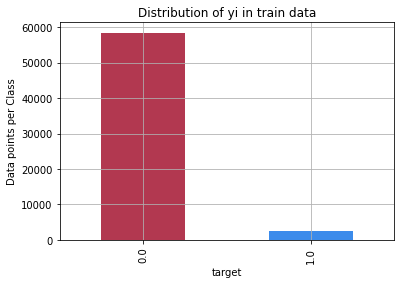

Number of data points in class 1 : 58404 ( 96.043 %)
Number of data points in class 2 : 2406 ( 3.957 %)
--------------------------------------------------------------------------------


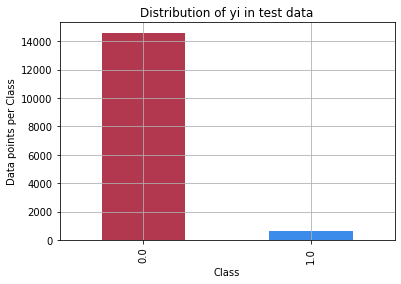

Number of data points in class 1 : 14601 ( 96.04 %)
Number of data points in class 2 : 602 ( 3.96 %)
=====splitting the train data into 50-50 sets=====
the shape of the traindataset D1:  (30405, 249) (30405,)
the shape of the traindataset D2:  (30405, 249) (30405,)


100%|██████████| 5/5 [01:10<00:00, 14.10s/it]


This dataset having 30405 rows and 5 columns.
dataset have 0 integer type & 4 float type & 1 object type
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30405 entries, 0 to 30404
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   model_predict1  30405 non-null  float64
 1   model_predict2  30405 non-null  float64
 2   model_predict3  30405 non-null  float32
 3   model_predict4  30405 non-null  float64
 4   model_predict5  30405 non-null  float64
dtypes: float32(1), float64(4)
memory usage: 1.0 MB
None
--------------------------------------------------
====================tested set====================
=============predicting the values :==============


100%|██████████| 5/5 [00:32<00:00,  6.53s/it]


This dataset having 75818 rows and 5 columns.
dataset have 0 integer type & 4 float type & 1 object type
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75818 entries, 0 to 75817
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   model_predict1  75818 non-null  float64
 1   model_predict2  75818 non-null  float64
 2   model_predict3  75818 non-null  float32
 3   model_predict4  75818 non-null  float64
 4   model_predict5  75818 non-null  float64
dtypes: float32(1), float64(4)
memory usage: 2.6 MB
None
--------------------------------------------------
test_auc:  0.8206376548641255


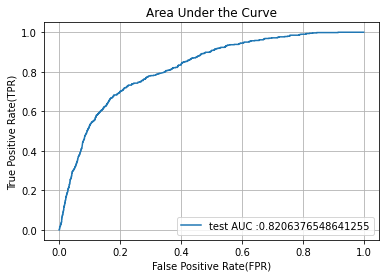

In [ ]:
y_predicted_base_vals = custom_stacking_base(dataframe_train,dataframe_test,5)
#
samp_sub =pd.read_csv("sample_submission.csv")

# creating submission file 
submit_custom_stacking_base = pd.DataFrame({ "ID": samp_sub.ID, "TARGET": y_predicted_base_vals})


submit_custom_stacking_base.to_csv("custom_stacking_base.csv", index=False)

the shape of the  train dataset : (60810, 249) (60810,)
the shape of the test dataset : (15203, 249) (15203,)
the shape of the traindataset D1:  (30405, 249) (30405,)
the shape of the traindataset D2:  (30405, 249) (30405,)
This dataset having 30405 rows and 5 columns.
dataset have 0 integer type & 4 float type & 1 object type
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30405 entries, 0 to 30404
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   model_predict1  30405 non-null  float64
 1   model_predict2  30405 non-null  float64
 2   model_predict3  30405 non-null  float32
 3   model_predict4  30405 non-null  float64
 4   model_predict5  30405 non-null  float64
dtypes: float32(1), float64(4)
memory usage: 1.0 MB
None
--------------------------------------------------
test_auc:  0.8283580790557056


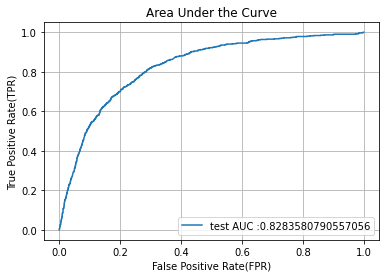

array([0.01736448, 0.26318573, 0.02198854, ..., 0.01847542, 0.26412946,
       0.01774662])

In [ ]:
custom_stacking_base(dataframe_train,5)

# SMOTE

In [ ]:
#dataset_analysis(data["data2"])

In [ ]:

def base_models():
  models={}
  models["model1"] = LogisticRegression(penalty="l2",C=100)
  models["model2"] = DecisionTreeClassifier(max_depth=10,min_samples_split=500)
  models["model3"] = XGBClassifier(n_estimators=200,max_depth=4)
  models["model5"] = SVC(kernel="rbf",C=1,probability=True)
  models["model4"]  = RandomForestClassifier(n_estimators=500,max_depth=7)
  return models

In [ ]:
# modl = ["lr","DT","Xgb","svm","RF"]
models = base_models()
for i in models.values():
  print(i)

LogisticRegression(C=100)
DecisionTreeClassifier(max_depth=10, min_samples_split=500)
XGBClassifier(max_depth=4, n_estimators=200)
SVC(C=1, probability=True)
RandomForestClassifier(max_depth=7, n_estimators=500)


In [ ]:
print("hi".center(50,"="))

========================hi========================


In [ ]:
from tqdm import tqdm
def k_samples_data(dataset,no_of_samples):
  datasampl = {}  # create dictionary to store the newly sampled datasets.
  for i in range(1,no_of_samples):
    datasampl["data%s"%i] = dataset.sample(frac=0.5,replace=True) # take the 50% of the data from the dataset for each sample
  return datasampl

def base_models_smote():
  models={}
  models["model1"] = LogisticRegression(C=10,penalty="l2")
  models["model2"] = DecisionTreeClassifier(max_depth=50,min_samples_split=100)
  models["model3"] = XGBClassifier(n_estimators=100,max_depth=8)
  models["model5"] = SVC(kernel="rbf",C=1,probability=True)
  models["model4"]  = RandomForestClassifier(n_estimators=150,max_depth=8)
  return models
def custom_stacking_smote(dataframe_train,dataframe_test,k):
  # takes the features set and labels from the dataset.
  X = dataframe_train.drop(["ID","TARGET"],axis=1)
  Y = dataframe_train["TARGET"]

  # split your whole data into train and test(80-20)
  X_train,X_test,Y_train,Y_test = train_test_split(X,Y,train_size=0.8,stratify=Y)
  print("the shape of the  train dataset :",X_train.shape,Y_train.shape)
  print("the shape of the test dataset :",X_test.shape,Y_test.shape)
  
  from imblearn.over_sampling import ADASYN,SMOTE
  from collections import Counter
  counter = Counter(Y_train)
  print("before sampling : ",counter)
  # transform the dataset
  oversample = SMOTE()
  X_train, Y_train = oversample.fit_resample(X_train, Y_train)

  counter = Counter(Y_train)
  print("after sampling",counter)
  class_distribution(Y_train,Y_test)

  print("splitting the train data into 50-50 sets".center(50,"="))
  # b) Now, in the 80% train set, split the train set into D1 and D2.(50-50).
  x_train1,x_train2,y_train1,y_train2 = train_test_split(X_train,Y_train,train_size=0.5,stratify=Y_train)
  print("the shape of the traindataset D1: ",x_train1.shape,y_train1.shape)
  print("the shape of the traindataset D2: ",x_train2.shape,y_train2.shape)
  #class_distribution(y_train1,y_train2)
  # creating the datasets 
  D1 = pd.concat([x_train1,y_train1],axis=1)
  D2 = pd.concat([x_train2,y_train2],axis=1)

  

  sampledata = k_samples_data(D1,k+1) # we provide the dataset and no of samples
  
  base_model_set = base_models_smote() # model set

  # fitting the models
  fitted = {} # create an empty dictionary to store the fitted models
  predicted = {} # create an empty dictionary to store the predicted values.
  test_predicted = {}
  for i in tqdm(range(1,k+1)):
    # load the sampled datasets 
    x1 = sampledata["data"+str(i)].drop(["TARGET"],axis=1) # "ID",
    y1 = sampledata["data"+str(i)]["TARGET"]
    # fit the sampled dataset on models
    fitted["fit%s"%i]=base_model_set["model"+str(i)].fit(x1,y1)

    # predict the values based on the fitted models

    predicted["model_predict%s"%i]=fitted["fit"+str(i)].predict_proba(x_train2)[:,1] # 40%dataset from the train data D2.
    
  predicted_dataset = pd.DataFrame(predicted) # create the dataset for the predicted the probabilities.
  dataset_analysis(predicted_dataset)
  # https://medium.com/ml-research-lab/stacking-ensemble-meta-algorithms-for-improve-predictions-f4b4cf3b9237


  print("tested set".center(50,"="))
  
  # train the meta classsifier  on the predicted probability values from the models.


  lr= LogisticRegression() # meta classifier as lr
  lr.fit(predicted_dataset, y_train2) # fit into the data predicted values of the models and original train points of the dataset D2.

  print("predicting the values :".center(50,"="))
  # evaluation
  eval_preds = {} # create empty dictionary to store the evaluated predicted values.
  for i in tqdm(range(1,k+1)):
    eval_preds["model_predict%s"%i]=fitted["fit"+str(i)].predict_proba(X_test)[:,1] # 20% of the test set values
    #test set prediction
    test_predicted["model_predict%s"%i]=fitted["fit"+str(i)].predict_proba(dataframe_test[x_train2.columns])[:,1] # take the columns in the train data from the test dataset


  # create new dataframe with predicted probability values on the 20% of the testing data  from the training set.
  eval_predicted = pd.DataFrame(eval_preds)
  final = lr.predict_proba(eval_predicted)[:,1] #predicted values on the model predicted values.
  
  
  # create the new dataframe with predicted probability values on the test set values. by using the meta classifier 
  test_predicted_dataset = pd.DataFrame(test_predicted)
  dataset_analysis(test_predicted_dataset)
  final_test_predict_score = lr.predict_proba(test_predicted_dataset)[:,1]


  
  # got the tpr,fpr and thresholds from the roc-curve metric
  #train_fpr1 , train_tpr1 ,train_thresholds1= roc_curve(y_train,y_train_pred1)
  test_fpr1 , test_tpr1 ,test_thresholds1 = roc_curve(Y_test,final)

  # auc takes fpr , tpr gives the auc value
  test_auc21 = auc(test_fpr1,test_tpr1)
  print("test_auc: ",test_auc21)

  #plt.plot(train_fpr1,train_tpr1,label="train AUC:"+str(auc(train_fpr1,train_tpr1)))
  plt.plot(test_fpr1,test_tpr1,label="test AUC :"+str(auc(test_fpr1,test_tpr1)))
  plt.legend()
  plt.xlabel("False Positive Rate(FPR)")
  plt.ylabel("True Positive Rate(TPR)")

  plt.title("Area Under the Curve")
  plt.grid()
  plt.show()

  
  return final_test_predict_score


In [ ]:
dataframe_test = pd.read_csv("test.csv")
dataset_analysis(dataframe_test)

This dataset having 75818 rows and 370 columns.
dataset have 260 integer type & 110 float type & 0 object type
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75818 entries, 0 to 75817
Columns: 370 entries, ID to var38
dtypes: float64(110), int64(260)
memory usage: 214.0 MB
None
--------------------------------------------------


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var1,ind_var2_0,ind_var2,ind_var5_0,ind_var5,ind_var6_0,ind_var6,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13_largo,ind_var13_medio_0,ind_var13_medio,ind_var13,ind_var14_0,ind_var14,ind_var17_0,ind_var17,ind_var18_0,ind_var18,ind_var19,ind_var20_0,ind_var20,ind_var24_0,ind_var24,ind_var25_cte,ind_var26_0,ind_var26_cte,ind_var26,ind_var25_0,ind_var25,ind_var27_0,ind_var28_0,ind_var28,ind_var27,ind_var29_0,ind_var29,ind_var30_0,ind_var30,ind_var31_0,ind_var31,ind_var32_cte,ind_var32_0,ind_var32,ind_var33_0,ind_var33,ind_var34_0,ind_var34,ind_var37_cte,ind_var37_0,ind_var37,ind_var39_0,ind_var40_0,ind_var40,ind_var41_0,ind_var41,ind_var39,ind_var44_0,ind_var44,ind_var46_0,ind_var46,num_var1_0,num_var1,num_var4,num_var5_0,num_var5,num_var6_0,num_var6,num_var8_0,num_var8,num_var12_0,num_var12,num_var13_0,num_var13_corto_0,num_var13_corto,num_var13_largo_0,num_var13_largo,num_var13_medio_0,num_var13_medio,num_var13,num_var14_0,num_var14,num_var17_0,num_var17,num_var18_0,num_var18,num_var20_0,num_var20,num_var24_0,num_var24,num_var26_0,num_var26,num_var25_0,num_var25,num_op_var40_hace2,num_op_var40_hace3,num_op_var40_ult1,num_op_var40_ult3,num_op_var41_hace2,num_op_var41_hace3,num_op_var41_ult1,num_op_var41_ult3,num_op_var39_hace2,num_op_var39_hace3,num_op_var39_ult1,num_op_var39_ult3,num_var27_0,num_var28_0,num_var28,num_var27,num_var29_0,num_var29,num_var30_0,num_var30,num_var31_0,num_var31,num_var32_0,num_var32,num_var33_0,num_var33,num_var34_0,num_var34,num_var35,num_var37_med_ult2,num_var37_0,num_var37,num_var39_0,num_var40_0,num_var40,num_var41_0,num_var41,num_var39,num_var42_0,num_var42,num_var44_0,num_var44,num_var46_0,num_var46,saldo_var1,saldo_var5,saldo_var6,saldo_var8,saldo_var12,saldo_var13_corto,saldo_var13_largo,saldo_var13_medio,saldo_var13,saldo_var14,saldo_var17,saldo_var18,saldo_var20,saldo_var24,saldo_var26,saldo_var25,saldo_var28,saldo_var27,saldo_var29,saldo_var30,saldo_var31,saldo_var32,saldo_var33,saldo_var34,saldo_var37,saldo_var40,saldo_var41,saldo_var42,saldo_var44,saldo_var46,var36,delta_imp_amort_var18_1y3,delta_imp_amort_var34_1y3,delta_imp_aport_var13_1y3,delta_imp_aport_var17_1y3,delta_imp_aport_var33_1y3,delta_imp_compra_var44_1y3,delta_imp_reemb_var13_1y3,delta_imp_reemb_var17_1y3,delta_imp_reemb_var33_1y3,delta_imp_trasp_var17_in_1y3,delta_imp_trasp_var17_out_1y3,delta_imp_trasp_var33_in_1y3,delta_imp_trasp_var33_out_1y3,delta_imp_venta_var44_1y3,delta_num_aport_var13_1y3,delta_num_aport_var17_1y3,delta_num_aport_var33_1y3,delta_num_compra_var44_1y3,delta_num_reemb_var13_1y3,delta_num_reemb_var17_1y3,delta_num_reemb_var33_1y3,delta_num_trasp_var17_in_1y3,delta_num_trasp_var17_out_1y3,delta_num_trasp_var33_in_1y3,delta_num_trasp_var33_out_1y3,delta_num_venta_var44_1y3,imp_amort_var18_hace3,imp_amort_var18_ult1,imp_amort_var34_hace3,imp_amort_var34_ult1,imp_aport_var13_hace3,imp_aport_var13_ult1,imp_aport_var17_hace3,imp_aport_var17_ult1,imp_aport_var33_hace3,imp_aport_var33_ult1,imp_var7_emit_ult1,imp_var7_recib_ult1,imp_compra_var44_hace3,imp_compra_var44_ult1,imp_reemb_var13_hace3,imp_reemb_var13_ult1,imp_reemb_var17_hace3,imp_reemb_var17_ult1,imp_reemb_var33_hace3,imp_reemb_var33_ult1,imp_var43_emit_ult1,imp_trans_var37_ult1,imp_trasp_var17_in_hace3,imp_trasp_var17_in_ult1,imp_trasp_var17_out_hace3,imp_trasp_var17_out_ult1,imp_trasp_var33_in_hace3,imp_trasp_var33_in_ult1,imp_trasp_var33_out_hace3,imp_trasp_var33_out_ult1,imp_venta_var44_hace3,imp_venta_var44_ult1,ind_var7_emit_ult1,ind_var7_recib_ult1,ind_var10_ult1,ind_var10

the shape of the  train dataset : (60810, 249) (60810,)
the shape of the test dataset : (15203, 249) (15203,)
before sampling :  Counter({0.0: 58404, 1.0: 2406})
after sampling Counter({0.0: 58404, 1.0: 58404})


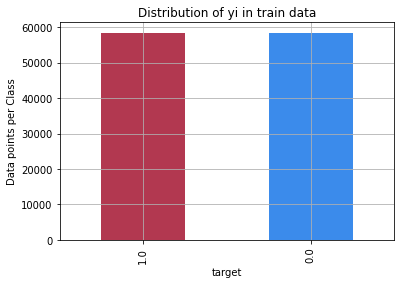

Number of data points in class 1 : 58404 ( 50.0 %)
Number of data points in class 2 : 58404 ( 50.0 %)
--------------------------------------------------------------------------------


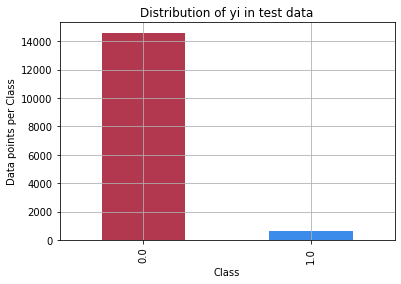

Number of data points in class 1 : 14601 ( 96.04 %)
Number of data points in class 2 : 602 ( 3.96 %)
=====splitting the train data into 50-50 sets=====
the shape of the traindataset D1:  (58404, 249) (58404,)
the shape of the traindataset D2:  (58404, 249) (58404,)


100%|██████████| 5/5 [43:49<00:00, 525.98s/it]


This dataset having 58404 rows and 5 columns.
dataset have 0 integer type & 4 float type & 1 object type
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58404 entries, 0 to 58403
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   model_predict1  58404 non-null  float64
 1   model_predict2  58404 non-null  float64
 2   model_predict3  58404 non-null  float32
 3   model_predict4  58404 non-null  float64
 4   model_predict5  58404 non-null  float64
dtypes: float32(1), float64(4)
memory usage: 2.0 MB
None
--------------------------------------------------
====================tested set====================
This dataset having 75818 rows and 5 columns.
dataset have 0 integer type & 4 float type & 1 object type
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75818 entries, 0 to 75817
Data columns (total 5 columns)

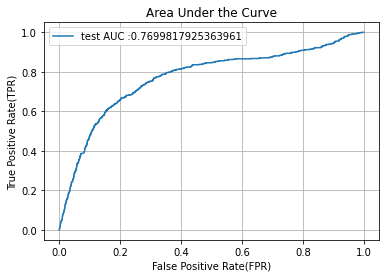

In [ ]:
y_predicted_smote_vals = custom_stacking_smote(dataframe_train,dataframe_test,5)


In [ ]:
#
samp_sub =pd.read_csv("sample_submission.csv")

# creating submission file 
submit_custom_stacking_smote = pd.DataFrame({ "ID": samp_sub.ID, "TARGET": y_predicted_smote_vals})


submit_custom_stacking_smote.to_csv("custom_stacking_smote.csv", index=False)

# ADASYN

In [ ]:
from tqdm import tqdm
def k_samples_data(dataset,no_of_samples):
  datasampl = {}  # create dictionary to store the newly sampled datasets.
  for i in range(1,no_of_samples):
    datasampl["data%s"%i] = dataset.sample(frac=0.5,replace=True)
  return datasampl

def base_models_adasyn():
  models={}
  models["model1"] = LogisticRegression(C=0.01,penalty="l2")
  models["model2"] = DecisionTreeClassifier(max_depth=50,min_samples_split=100)
  models["model3"] = XGBClassifier(n_estimators=200,max_depth=8)
  models["model5"] = SVC(kernel="rbf",C=1,probability=True)
  models["model4"]  = RandomForestClassifier(n_estimators=300,max_depth=8)
  return models


def custom_stacking_ada(dataframe_train,dataframe_test,k):
    # takes the features set and labels from the dataset.
    X = dataframe_train.drop(["ID","TARGET"],axis=1)
    Y = dataframe_train["TARGET"]

    # split your whole data into train and test(80-20)
    X_train,X_test,Y_train,Y_test = train_test_split(X,Y,train_size=0.8,stratify=Y)
    print("the shape of the  train dataset :",X_train.shape,Y_train.shape)
    print("the shape of the test dataset :",X_test.shape,Y_test.shape)
  
    from imblearn.over_sampling import ADASYN,SMOTE
    from collections import Counter
    counter = Counter(Y_train)
    print("before sampling : ",counter)
    # transform the dataset
    oversample = ADASYN()
    X_train, Y_train = oversample.fit_resample(X_train, Y_train)

    counter = Counter(Y_train)
    print("after sampling",counter)
    class_distribution(Y_train,Y_test)

    print("splitting the train data into 50-50 sets".center(50,"="))
    # b) Now, in the 80% train set, split the train set into D1 and D2.(50-50).
    x_train1,x_train2,y_train1,y_train2 = train_test_split(X_train,Y_train,train_size=0.5,stratify=Y_train)
    print("the shape of the traindataset D1: ",x_train1.shape,y_train1.shape)
    print("the shape of the traindataset D2: ",x_train2.shape,y_train2.shape)
    #class_distribution(y_train1,y_train2)
    # creating the datasets 
    D1 = pd.concat([x_train1,y_train1],axis=1)
    D2 = pd.concat([x_train2,y_train2],axis=1)

  
    # do sampling with replacement to create d1,d2,d3....dk(k samples).
    #Now create 'k' models and train each of these models with the samples. Each model will be trained on only one sample. These models are called base models. We can select the best model and its hyperparameters based on the previous findings. Make sure that ‘k’ can be passed as an argument. 

    sampledata = k_samples_data(D1,k+1) # we provide the dataset and no of samples
  
    base_model_set = base_models_adasyn() # model set

    # fitting the models
    fitted = {} # create an empty dictionary to store the fitted models
    predicted = {} # create an empty dictionary to store the predicted values.
    test_predicted = {}
    for i in tqdm(range(1,k+1)):
      # load the sampled datasets 
      x1 = sampledata["data"+str(i)].drop(["TARGET"],axis=1) # "ID",
      y1 = sampledata["data"+str(i)]["TARGET"]
      # fit the sampled dataset on models
      fitted["fit%s"%i]=base_model_set["model"+str(i)].fit(x1,y1)

      # predict the values based on the fitted models

      predicted["model_predict%s"%i]=fitted["fit"+str(i)].predict_proba(x_train2)[:,1] # 40%dataset from the train data D2.
    
    predicted_dataset = pd.DataFrame(predicted) # create the dataset for the predicted the probabilities.
    dataset_analysis(predicted_dataset)
    # https://medium.com/ml-research-lab/stacking-ensemble-meta-algorithms-for-improve-predictions-f4b4cf3b9237
    print("tested set".center(50,"="))
  
    # train the meta classsifier  on the predicted probability values from the models.

    lr= LogisticRegression() # meta classifier as lr
    lr.fit(predicted_dataset, y_train2) # fit into the data

    print("predicting the values :".center(50,"="))
    # evaluation
    eval_preds = {} # create empty dictionary to store the evaluated predicted values.
    for i in tqdm(range(1,k+1)):
      eval_preds["model_predict%s"%i]=fitted["fit"+str(i)].predict_proba(X_test)[:,1] # 20% of the test set values
      #test set prediction
      test_predicted["model_predict%s"%i]=fitted["fit"+str(i)].predict_proba(dataframe_test[x_train2.columns])[:,1] # take the columns in the train data.

    eval_predicted = pd.DataFrame(eval_preds)
    final = lr.predict_proba(eval_predicted)[:,1] #predicted values on the model predicted values.
  
  
    # create the new dataframe with predicted probability values on the test set values.
    test_predicted_dataset = pd.DataFrame(test_predicted)
    dataset_analysis(test_predicted_dataset)
    final_test_predict_score = lr.predict_proba(test_predicted_dataset)[:,1]


  
    # got the tpr,fpr and thresholds from the roc-curve metric
    #train_fpr1 , train_tpr1 ,train_thresholds1= roc_curve(y_train,y_train_pred1)
    test_fpr1 , test_tpr1 ,test_thresholds1 = roc_curve(Y_test,final)

    # auc takes fpr , tpr gives the auc value
    test_auc21 = auc(test_fpr1,test_tpr1)
    print("test_auc: ",test_auc21)

    #plt.plot(train_fpr1,train_tpr1,label="train AUC:"+str(auc(train_fpr1,train_tpr1)))
    plt.plot(test_fpr1,test_tpr1,label="test AUC :"+str(auc(test_fpr1,test_tpr1)))
    plt.legend()
    plt.xlabel("False Positive Rate(FPR)")
    plt.ylabel("True Positive Rate(TPR)")

    plt.title("Area Under the Curve")
    plt.grid()
    plt.show()

  
    return final_test_predict_score


the shape of the  train dataset : (60810, 249) (60810,)
the shape of the test dataset : (15203, 249) (15203,)
before sampling :  Counter({0.0: 58404, 1.0: 2406})
after sampling Counter({1.0: 58702, 0.0: 58404})


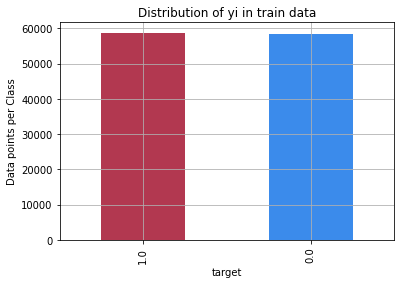

Number of data points in class 1 : 58702 ( 50.127 %)
Number of data points in class 2 : 58404 ( 49.873 %)
--------------------------------------------------------------------------------


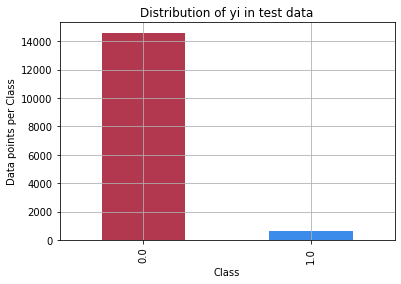

Number of data points in class 1 : 14601 ( 96.04 %)
Number of data points in class 2 : 602 ( 3.96 %)
=====splitting the train data into 50-50 sets=====
the shape of the traindataset D1:  (58553, 249) (58553,)
the shape of the traindataset D2:  (58553, 249) (58553,)


100%|██████████| 5/5 [44:21<00:00, 532.32s/it]


This dataset having 58553 rows and 5 columns.
dataset have 0 integer type & 4 float type & 1 object type
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58553 entries, 0 to 58552
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   model_predict1  58553 non-null  float64
 1   model_predict2  58553 non-null  float64
 2   model_predict3  58553 non-null  float32
 3   model_predict4  58553 non-null  float64
 4   model_predict5  58553 non-null  float64
dtypes: float32(1), float64(4)
memory usage: 2.0 MB
None
--------------------------------------------------
====================tested set====================
=============predicting the values :==============


100%|██████████| 5/5 [17:42<00:00, 212.43s/it]


This dataset having 75818 rows and 5 columns.
dataset have 0 integer type & 4 float type & 1 object type
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75818 entries, 0 to 75817
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   model_predict1  75818 non-null  float64
 1   model_predict2  75818 non-null  float64
 2   model_predict3  75818 non-null  float32
 3   model_predict4  75818 non-null  float64
 4   model_predict5  75818 non-null  float64
dtypes: float32(1), float64(4)
memory usage: 2.6 MB
None
--------------------------------------------------
test_auc:  0.794701063800982


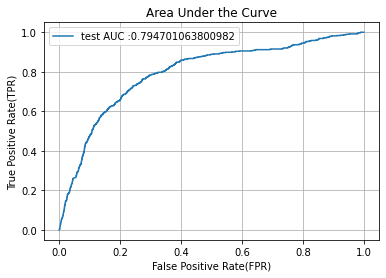

In [ ]:
y_predicted_adasyn_vals = custom_stacking_ada(dataframe_train,dataframe_test,5)

In [ ]:
#
samp_sub =pd.read_csv("sample_submission.csv")

# creating submission file 
submit_custom_stacking_adasyn = pd.DataFrame({ "ID": samp_sub.ID, "TARGET": y_predicted_adasyn_vals})


submit_custom_stacking_adasyn.to_csv("custom_stacking_adasyn.csv", index=False)

#my kaggle result

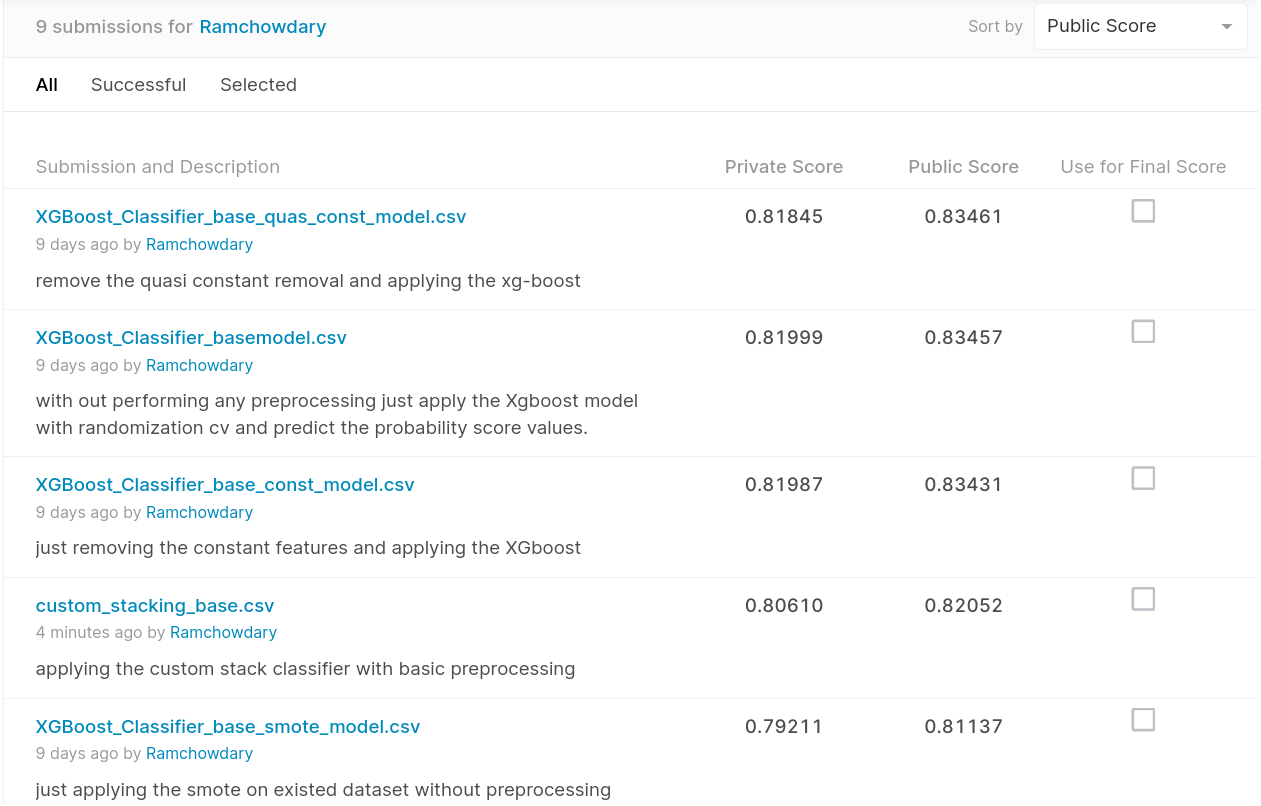

# roof

In [ ]:
def custom_cascade_ada(df,k):
  # takes the features set and labels from the dataset.
  X = df.drop(["ID","TARGET"],axis=1)
  Y = df["TARGET"]

  # split your whole data into train and test(80-20)
  X_train,X_test,Y_train,Y_test = train_test_split(X,Y,train_size=0.8,stratify=Y)
  print("the shape of the  train dataset :",X_train.shape,Y_train.shape)
  print("the shape of the test dataset :",X_test.shape,Y_test.shape)
  #class_distribution(Y_train,Y_test)
  from imblearn.over_sampling import ADASYN,SMOTE
  from collections import Counter
  counter = Counter(Y_train)
  print("before sampling : ",counter)
  # transform the dataset
  oversample = ADASYN()
  X_train, Y_train = oversample.fit_resample(X_train, Y_train)

  counter = Counter(Y_train)
  print("after sampling",counter)

  # b) Now, in the 80% train set, split the train set into D1 and D2.(50-50).
  x_train1,x_train2,y_train1,y_train2 = train_test_split(X_train,Y_train,train_size=0.5,stratify=Y_train)
  print("the shape of the traindataset D1: ",x_train1.shape,y_train1.shape)
  print("the shape of the traindataset D2: ",x_train2.shape,y_train2.shape)
  #class_distribution(y_train1,y_train2)
  # creating the datasets 
  D1 = pd.concat([x_train1,y_train1],axis=1)
  D2 = pd.concat([x_train2,y_train2],axis=1)

  

  sampledata = k_samples_data(D1,k+1) # we provide the dataset and no of samples
  
  base_model_set = base_models2() # model set

  # fitting the models
  fitted = {} # create an empty dictionary to store the fitted models
  predicted = {} # create an empty dictionary to store the predicted values.
  for i in tqdm(range(1,k+1)):
    # load the sampled datasets 
    x1 = sampledata["data"+str(i)].drop(["TARGET"],axis=1) # "ID",
    y1 = sampledata["data"+str(i)]["TARGET"]
    # fit the sampled dataset on models
    fitted["fit%s"%i]=base_model_set["model"+str(i)].fit(x1,y1)
    # predict the values 
    predicted["model_predict%s"%i]=fitted["fit"+str(i)].predict_proba(x_train2)[:,1] # 40%dataset from the train data D2.

  predicted_dataset = pd.DataFrame(predicted) # create the dataset for the predicted the probabilities.
  dataset_analysis(predicted_dataset)
  # https://medium.com/ml-research-lab/stacking-ensemble-meta-algorithms-for-improve-predictions-f4b4cf3b9237
  lr= LogisticRegression() # meta classifier as lr
  lr.fit(predicted_dataset, y_train2) # fit into the data


  # evaluation
  eval_preds = {} # create empty dictionary to store the evaluated predicted values.
  for i in range(1,k+1):
    eval_preds["model_predict%s"%i]=fitted["fit"+str(i)].predict_proba(X_test)[:,1] # 20% of the test set values
  eval_predicted = pd.DataFrame(eval_preds)



  final = lr.predict(eval_predicted) #predicted points.

  # got the tpr,fpr and thresholds from the roc-curve metric
  #train_fpr1 , train_tpr1 ,train_thresholds1= roc_curve(y_train,y_train_pred1)
  test_fpr1 , test_tpr1 ,test_thresholds1 = roc_curve(Y_test,final)

  # auc takes fpr , tpr gives the auc value
  test_auc21 = auc(test_fpr1,test_tpr1)
  print("test_auc: ",test_auc21)

  #plt.plot(train_fpr1,train_tpr1,label="train AUC:"+str(auc(train_fpr1,train_tpr1)))
  plt.plot(test_fpr1,test_tpr1,label="test AUC :"+str(auc(test_fpr1,test_tpr1)))
  plt.legend()
  plt.xlabel("False Positive Rate(FPR)")
  plt.ylabel("True Positive Rate(TPR)")

  plt.title("Area Under the Curve")
  plt.grid()
  plt.show()
  return final

In [ ]:
def custom_stacking_base(df_train,k): # train dataset , no of models/samples as an input
  # takes the features set and labels from the dataset.
  X = df_train.drop(["ID","TARGET"],axis=1)
  Y = df_train["TARGET"]

  # split your whole data into train and test(80-20)
  X_train,X_test,Y_train,Y_test = train_test_split(X,Y,train_size=0.8,stratify=Y)
  print("the shape of the  train dataset :",X_train.shape,Y_train.shape)
  print("the shape of the test dataset :",X_test.shape,Y_test.shape)
  #class_distribution(Y_train,Y_test)

  # b) Now, in the 80% train set, split the train set into D1 and D2.(50-50).
  x_train1,x_train2,y_train1,y_train2 = train_test_split(X_train,Y_train,train_size=0.5,stratify=Y_train)
  print("the shape of the traindataset D1: ",x_train1.shape,y_train1.shape)
  print("the shape of the traindataset D2: ",x_train2.shape,y_train2.shape)
  #class_distribution(y_train1,y_train2)
  # creating the datasets 
  D1 = pd.concat([x_train1,y_train1],axis=1)
  D2 = pd.concat([x_train2,y_train2],axis=1)

  

  sampledata = k_samples_data(D1,k+1) # we provide the dataset and no of samples
  
  base_model_set = base_models_base() # model set

  # fitting the models
  fitted = {} # create an empty dictionary to store the fitted models
  predicted = {} # create an empty dictionary to store the predicted values.
  for i in range(1,k+1):
    # load the sampled datasets 
    x1 = sampledata["data"+str(i)].drop(["TARGET"],axis=1) # "ID",
    y1 = sampledata["data"+str(i)]["TARGET"]
    # fit the sampled dataset on models
    fitted["fit%s"%i]=base_model_set["model"+str(i)].fit(x1,y1)
    # predict the values 
    predicted["model_predict%s"%i]=fitted["fit"+str(i)].predict_proba(x_train2)[:,1] # 40%dataset from the train data D2.

  predicted_dataset = pd.DataFrame(predicted) # create the dataset for the predicted the probabilities.
  dataset_analysis(predicted_dataset)
  # https://medium.com/ml-research-lab/stacking-ensemble-meta-algorithms-for-improve-predictions-f4b4cf3b9237
  lr= LogisticRegression() # meta classifier as lr
  lr.fit(predicted_dataset, y_train2) # fit into the data


  # evaluation
  eval_preds = {} # create empty dictionary to store the evaluated predicted values.
  for i in range(1,k+1):
    eval_preds["model_predict%s"%i]=fitted["fit"+str(i)].predict_proba(X_test)[:,1] # 20% of the test set values
  eval_predicted = pd.DataFrame(eval_preds)

  final = lr.predict_proba(eval_predicted)[:,1] #predicted points.

  # got the tpr,fpr and thresholds from the roc-curve metric
  #train_fpr1 , train_tpr1 ,train_thresholds1= roc_curve(y_train,y_train_pred1)
  test_fpr1 , test_tpr1 ,test_thresholds1 = roc_curve(Y_test,final)

  # auc takes fpr , tpr gives the auc value
  test_auc21 = auc(test_fpr1,test_tpr1)
  print("test_auc: ",test_auc21)

  #plt.plot(train_fpr1,train_tpr1,label="train AUC:"+str(auc(train_fpr1,train_tpr1)))
  plt.plot(test_fpr1,test_tpr1,label="test AUC :"+str(auc(test_fpr1,test_tpr1)))
  plt.legend()
  plt.xlabel("False Positive Rate(FPR)")
  plt.ylabel("True Positive Rate(TPR)")

  plt.title("Area Under the Curve")
  plt.grid()
  plt.show()
  return final
